In [1]:
%load_ext autoreload
%autoreload 2
import multibind as mb
import numpy as np
import pandas as pd
import torch
import torch.optim as topti
import torch.utils.data as tdata
import bindome as bd
bd.constants.ANNOTATIONS_DIRECTORY = '../annotations'
import matplotlib.pyplot as plt
import seaborn as sns
import logomaker
import os
import scipy
import pickle

# Use a GPU if available, as it should be faster.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: " + str(device))

/home/johanna/anaconda3/envs/multibind/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cpu


In [2]:
matlab_path = os.path.join(bd.constants.ANNOTATIONS_DIRECTORY, 'pbm', 'affreg', 'PbmDataHom6_norm.mat')
mat = scipy.io.loadmat(matlab_path)
data = mat['PbmData'][0]
seqs_dna =  data[0][5]
seqs_dna = [s[0][0] for s in seqs_dna]
# load the MSA sequences, one hot encoded
df, signal = bd.datasets.PBM.pbm_homeo_affreg()
# x, y = pickle.load(open('../../data/example_homeo_PbmData.pkl', 'rb'))
x, y = pickle.load(open('../annotations/pbm/example_homeo_PbmData.pkl', 'rb'))

In [4]:
# shift signal by adding a constant s.t. no negative values are included
signal -= np.min(signal)

In [5]:
# Set up the dataset
df = pd.DataFrame(signal.T)
df['seq'] = seqs_dna
df.index = df['seq']
del df['seq']

dataset = mb.datasets.ResiduePBMDataset(df, x)
train = tdata.DataLoader(dataset=dataset, batch_size=128, shuffle=True)

# Set up the model
model = mb.models.ProteinDNABinding(0, 1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()    # mean-squared error for regression
reconstruction_crit = torch.nn.CrossEntropyLoss()

In [6]:
mb.tl.train_network(model, train, device, optimizer, criterion, reconstruction_crit, num_epochs=20, exp_max=-1, log_each=1, verbose=2)

optimizing using <class 'torch.optim.adam.Adam'> and <class 'torch.nn.modules.loss.MSELoss'> n_epochs 20 early_stopping -1
lr= 0.001, weight_decay= 0, dir weight= 0
Epoch:  2, Loss: 42426.673321 , best epoch: 0 secs per epoch: 88.044 s
Epoch:  3, Loss: 35698.083227 , best epoch: 0 secs per epoch: 66.041 s
Epoch:  4, Loss: 21555.572518 , best epoch: 0 secs per epoch: 58.167 s
Epoch:  5, Loss: 12585.296067 , best epoch: 0 secs per epoch: 54.741 s
Epoch:  6, Loss: 8092.149880 , best epoch: 4 secs per epoch: 52.356 s
Epoch:  7, Loss: 5442.431517 , best epoch: 5 secs per epoch: 50.656 s
Epoch:  8, Loss: 3661.061214 , best epoch: 6 secs per epoch: 49.585 s
Epoch:  9, Loss: 2426.024269 , best epoch: 7 secs per epoch: 48.738 s
Epoch: 10, Loss: 1923.580578 , best epoch: 8 secs per epoch: 48.053 s
Epoch: 11, Loss: 1229.377278 , best epoch: 9 secs per epoch: 47.544 s
Epoch: 12, Loss: 888.375804 , best epoch: 10 secs per epoch: 47.197 s
Epoch: 13, Loss: 532.017007 , best epoch: 11 secs per epoch: 

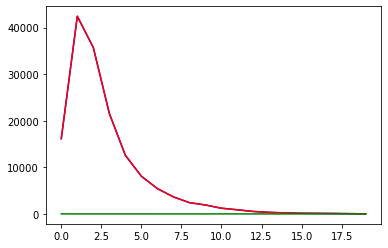

In [7]:
plt.plot(model.loss_history, 'b')
plt.plot(model.crit_history, 'r')
plt.plot(model.rec_history, 'g')

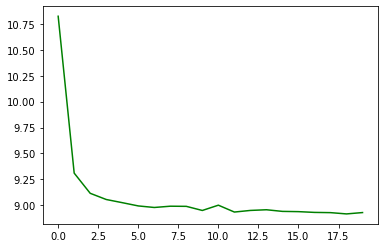

In [8]:
plt.plot(model.rec_history, 'g')

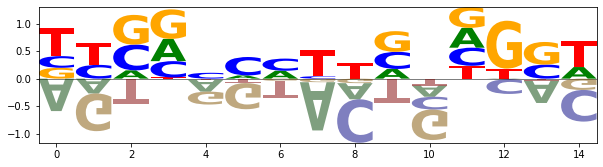

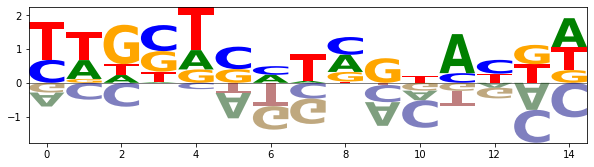

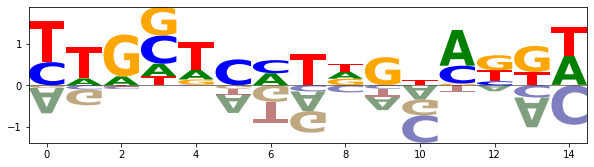

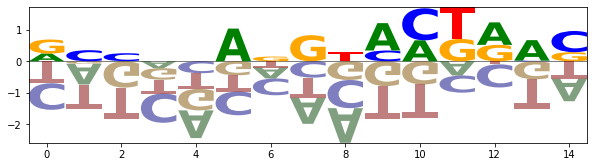

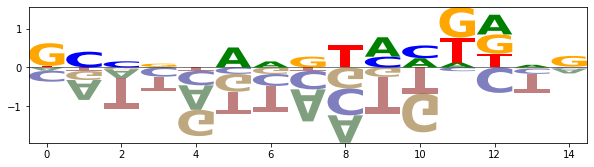

In [9]:
bm_pred = model.get_predicted_bm(torch.tensor(np.stack(x))[[0, 20, 50, 100, 150]])
bm_pred = bm_pred.cpu().detach().numpy()
for i in range(0, bm_pred.shape[0]):
    weights = bm_pred[i]
    weights = pd.DataFrame(weights)
    weights.index = "A", "C", "G", "T"
    crp_logo = logomaker.Logo(weights.T, shade_below=0.5, fade_below=0.5)

/home/johanna/anaconda3/envs/multibind/lib/python3.10/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


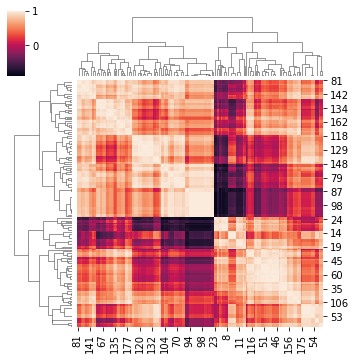

In [10]:
bm_pred = model.get_predicted_bm(torch.tensor(np.stack(x)))
bm_pred = bm_pred.cpu().detach().numpy()
bm_df = bm_pred.reshape(-1, 60)
bm_df = pd.DataFrame(bm_df.T)
corr = bm_df.corr()
import seaborn as sns
sns.clustermap(corr, figsize=[5, 5])